## 日経平均株価をLSTM・GRUで予測

下記のページから日経平均株価のCSVファイルをダウンロード。<br>
そして、RNNのモデルであるLSTM、GRUで株価の予測モデルを作成していきます。<br>
<br>
元データ:https://www.macrotrends.net/2593/nikkei-225-index-historical-chart-data  

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Dropout

from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [191]:
# データの読み込み
data = pd.read_csv('nikkei-225-index-historical-chart-data.csv',header=15)

In [192]:
# 表示して確認
data.head()

,date,value
0,1949/5/16,176.21
1,1949/5/17,174.80
2,1949/5/18,172.53
3,1949/5/19,171.34
4,1949/5/20,169.20


## データの前処理

In [193]:
# 2015年から2021年3月24日までのデータを使用
data = data[16341:]

In [194]:
data.head()

,date,value
16341,2015/1/5,17408.71
16342,2015/1/6,16883.19
16343,2015/1/7,16885.33
16344,2015/1/8,17167.10
16345,2015/1/9,17197.73


<AxesSubplot:>

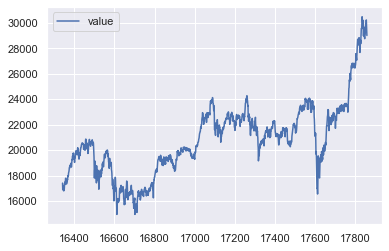

In [195]:
#時系列順に格納されているので日付データを削除
data = data.drop(['date'],axis =1)
data.plot()

上記が約５年間の株価の流れです。

In [196]:
# 時系列は３０日間を元に窓を作る
def _load_data(data, n_prev = 30):  
   
    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev])
        docY.append(data.iloc[i+n_prev])
    alsX = np.array(docX)
    alsY = np.array(docY)
 
    return alsX, alsY

In [197]:
# データを分割する関数を作成（１割をテストデータ）
def train_test_split(df, test_size=0.1, n_prev = 30):  
    
    ntrn = round(len(df) * (1 - test_size))
    ntrn = int(ntrn)
    X_train, y_train = _load_data(df.iloc[0:ntrn], n_prev)
    X_test, y_test = _load_data(df.iloc[ntrn:], n_prev)
 
    return (X_train, y_train), (X_test, y_test)

In [198]:
#正規化とデータ分割を実施
df = data / data.mean()
length_of_sequences = 30 #時系列数
(X_train, y_train), (X_test, y_test) = train_test_split(df, test_size = 0.1, n_prev = length_of_sequences)

## LSTMによる学習

In [199]:
length_of_sequences = X_train.shape[1]
hidden_neurons = 128 #中間層の数
in_out_neurons = 1 #出力の数
 
#LSTMモデル作成
model = Sequential()
model.add(LSTM(hidden_neurons, batch_input_shape=(None, length_of_sequences, in_out_neurons), return_sequences=False))
model.add(Dropout(0.25))#Dropoutは2.5割
model.add(Dense(1))  
model.add(Activation("linear")) #恒等関数で出力
 
model.compile(loss="mean_squared_error", optimizer="adam") #評価はMSE,最適化はAdam
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1) #10エポックごとにアーリーストッピングを検討
history = model.fit(X_train, y_train, batch_size=128, epochs=100, validation_split=0.1,callbacks=[early_stopping])

Epoch 1/100
10/10 [==============================] - 1s 51ms/step - loss: 0.5051 - val_loss: 0.1004
Epoch 2/100
10/10 [==============================] - 0s 24ms/step - loss: 0.0360 - val_loss: 0.0414
Epoch 3/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0180 - val_loss: 0.0092
Epoch 4/100
10/10 [==============================] - 0s 24ms/step - loss: 0.0113 - val_loss: 0.0048
Epoch 5/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0081 - val_loss: 0.0023
Epoch 6/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0067 - val_loss: 0.0023
Epoch 7/100
10/10 [==============================] - 0s 24ms/step - loss: 0.0068 - val_loss: 0.0024
Epoch 8/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0062 - val_loss: 0.0022
Epoch 9/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0068 - val_loss: 0.0023
Epoch 10/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0059 - val_loss: 0.0022

49回で学習が止まりました。<br>
そこからはモデルの改善ができないようです。<br>

<AxesSubplot:>

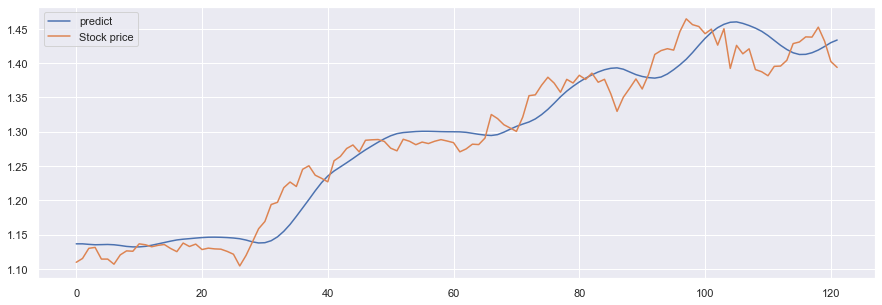

In [200]:
# 予測値算出
predicted = model.predict(X_test) 
# 実績と比較
dataf =  pd.DataFrame(predicted)
dataf.columns = ["predict"]
dataf["Stock price"] = y_test
dataf.plot(figsize=(15, 5))

大枠は予測できていますが、山の位置がずれています。<br>
この結果をGRUのときと比較してみます。

## GRUによる学習

LSTMとの違いを見るために、同条件での学習を行う。

In [202]:
model = Sequential()
model.add(GRU(hidden_neurons, batch_input_shape=(None, length_of_sequences, in_out_neurons), return_sequences=False))
model.add(Dropout(0.25))#念のためDropout
model.add(Dense(1))  
model.add(Activation("linear")) 
 
model.compile(loss="mean_squared_error", optimizer="adam")
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)
history = model.fit(X_train, y_train, batch_size=128, epochs=100, validation_split=0.1,callbacks=[early_stopping])

Epoch 1/100
10/10 [==============================] - 0s 48ms/step - loss: 0.4779 - val_loss: 0.0025
Epoch 2/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0546 - val_loss: 0.0037
Epoch 3/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0141 - val_loss: 0.0185
Epoch 4/100
10/10 [==============================] - 0s 21ms/step - loss: 0.0128 - val_loss: 0.0013
Epoch 5/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0083 - val_loss: 0.0017
Epoch 6/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0072 - val_loss: 0.0025
Epoch 7/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0069 - val_loss: 0.0015
Epoch 8/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0065 - val_loss: 0.0012
Epoch 9/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0060 - val_loss: 0.0016
Epoch 10/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0067 - val_loss: 0.0012

10/10 [==============================] - 0s 19ms/step - loss: 0.0029 - val_loss: 5.8062e-04
Epoch 81/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0024 - val_loss: 5.9431e-04
Epoch 82/100
10/10 [==============================] - 0s 19ms/step - loss: 0.0026 - val_loss: 5.7731e-04
Epoch 83/100
10/10 [==============================] - 0s 19ms/step - loss: 0.0027 - val_loss: 6.4223e-04
Epoch 84/100
10/10 [==============================] - 0s 19ms/step - loss: 0.0028 - val_loss: 6.4974e-04
Epoch 85/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0027 - val_loss: 6.1835e-04
Epoch 86/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0026 - val_loss: 8.8641e-04
Epoch 87/100
10/10 [==============================] - 0s 19ms/step - loss: 0.0026 - val_loss: 6.0206e-04
Epoch 88/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0026 - val_loss: 6.8621e-04
Epoch 89/100
10/10 [==============================] - 0s 20ms/step -

決めていたエポック数の１００回は学習しきりました。<br>
さらに増やせば改善ができるかもしれません。<br>
このまま結果を可視化してみます。

<AxesSubplot:>

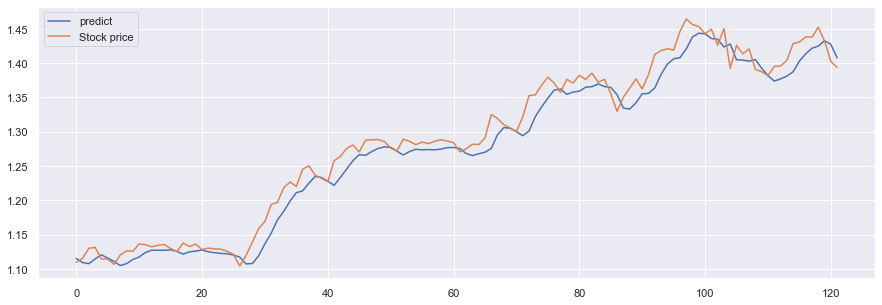

In [203]:
predicted = model.predict(X_test) 
# 実績と比較
dataf =  pd.DataFrame(predicted)
dataf.columns = ["predict"]
dataf["Stock price"] = y_test
dataf.plot(figsize=(15, 5))

LSTMよりも株価の変動の特徴を捉えているように見えます。<br>
このケースではGRUのほうが優秀なモデルといえるでしょう。<br>
※ちなみにデータ量を増やすと、どちらも予測精度はほぼ違いがありませんでした。<br>